# Eliminate Epistemic Uncertainty with `capsa` 
###  A Python Library for Deep Learning Model Risk Management

--------------------

#### Section 1: What is Epistemic Uncertainty? 

Epistemic uncertainty reflects the uncertainty that is inherent in a model's predictions due to the limited amount of information that the model has. This is in contrast to aleatoric uncertainty, which is uncertainty that arises from randomness or inherent noise in the data.

Knowing the epistemic uncertainty of a model can be important for a number of reasons: 

1. It can help us to understand the limitations of the model and know when it is likely to make inaccurate predictions. This can be useful for identifying situations where the model should be used with caution, or where it may not be appropriate to use it at all.

2. Knowing the epistemic uncertainty of a model can also help us to identify areas where the model is unsure of its predictions. This can be useful for identifying areas where the model may benefit from additional training data, or where it may be necessary to use a different model altogether.

------------------------------

#### Section 2: ``capsa`` (a Python Library for Mitigating Uncertainty)

Capsa is a convenient model wrapping tool. It wraps around predefined Keras models, adding the ability to perform risk analysis on the predictions made by those models, and therefore letting developers make more informed decisions about how to use it in their applications.

``capsa`` allows users to select a MetricWrapper that augments model with a corresponding risk-metric:

- **Representation Bias**: Bias of a dataset that exists in a target feature space in the model 
    - HistogramWrapper
- **Aleatoric Uncertainty**: Uncertainty that results from randomness or inherent noise in the data
    - MVEWrapper
- **Epistemic Uncertainty**: Uncertainty in a model's predictions due to model limitations or limited data
    - DropoutWrapper
    - EnsembleWrapper
    - VAEWrapper


-----------------------

#### Section 3: ``EnsembleWrapper()``

<img src="EnsembleWrapper.png">

``EnsembleWrapper()`` takes in a model and copies the architecture ``num_members`` times. This new ensemble architecture is parallelizable with tensorflow. Since each individual model (ensemble) has different initialization weights, they will converge towards different points in the loss surface as they are being trained. Therefore, given an input, each of these ensembles will output different predictions. The variance of all ensemble outputs gives us the epistemic uncertainty, **R**.

-----------------------------------------

#### Section 4: How to use ``capsa``

##### Installation and Import

First of all, let's install ``capsa`` to our work environment with ``pip install capsa``.

In [1]:
!pip install ./capsa
!pip install Pillow==9.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./capsa
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for capsa: filename=capsa-0.0.0-py3-none-any.whl size=39925 sha256=19f99c3353a69a3c97f89a381210b8649cb45db55bb19c1c65da2d8572867c58
  Stored in directory: /tmp/pip-ephem-wheel-cache-l_8wbwtf/wheels/30/92/72/51cc688e4524fb22e3b2778b93b4141814001edebc749901ba
Successfully built capsa
  Attempting uninstall: capsa
    Found existing installation: capsa 0.0.0
    Uninstalling capsa-0.0.0:
      Successfully uninstalled capsa-0.0.0
Looking in indexes: https://pypi.org/si

Then, we can import all the necessary libraries, as well as the `EnsembleWrapper` class.

In [2]:
import h5py
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, concatenate, MaxPool2D, Input, Dropout, UpSampling2D

from capsa import EnsembleWrapper
from cityscapes_helper import cityscapes, residual_segnet

##### Loading a Dataset

We use a dataloader to load cityscapes training and test dataset into seperate arrays.

In [3]:
x_train, y_train, color_codes = cityscapes.load_data("cityscapes/", "zurich", 122)
x_test, y_test, _ = cityscapes.load_data("cityscapes/", "ulm", 95)

Loading 122 images from zurich
Loaded image #0 -- Total segments: 15
Loaded image #1 -- Total segments: 16
Loaded image #2 -- Total segments: 17
Loaded image #3 -- Total segments: 18
Loaded image #4 -- Total segments: 18
Loaded image #5 -- Total segments: 21
Loaded image #6 -- Total segments: 21
Loaded image #7 -- Total segments: 21
Loaded image #8 -- Total segments: 21
Loaded image #9 -- Total segments: 21
Loaded image #10 -- Total segments: 21
Loaded image #11 -- Total segments: 21
Loaded image #12 -- Total segments: 21
Loaded image #13 -- Total segments: 21
Loaded image #14 -- Total segments: 21
Loaded image #15 -- Total segments: 21
Loaded image #16 -- Total segments: 21
Loaded image #17 -- Total segments: 21
Loaded image #18 -- Total segments: 21
Loaded image #19 -- Total segments: 21
Loaded image #20 -- Total segments: 21
Loaded image #21 -- Total segments: 21
Loaded image #22 -- Total segments: 21
Loaded image #23 -- Total segments: 22
Loaded image #24 -- Total segments: 22
Load

##### Loading a Unet Model

In [13]:
model = residual_segnet(input_size=x_train.shape[1:], n_out=len(color_codes))

##### Wrapping Keras Model with EnsembleWrapper()

So far, we've only dealt with tensorflow and defined our model as a Keras.Model variable. We can pass this variable as a parameter to `EnsembleWrapper(model,num_members=10)`, which augments the model to become risk-aware. The new ``wrapped_model`` variable can be used just like the initial model during training and inference.  

In [14]:
wrapped_model = EnsembleWrapper(model,num_members=10)

##### Compiling and Fitting

Just like how we might do in a Keras model, we will predefine an optimizer as well as a loss_function to use. We can compile our wrapped model using keras provided tools.  

In [15]:
wrapped_model.compile(optimizer = tf.keras.optimizers.Adam(),loss=tf.keras.losses.SparseCategoricalCrossentropy())

Now, let's fit our model with the training data that we initially loaded. As it's fitting, you can manually inspect the loss metrics of each ensemble.

In [45]:
wrapped_model.fit(x_train,y_train,batch_size=10,epochs=30)

Epoch 1/20
13/13 [==============================] - 6s 465ms/step - usermodel_0_loss: 2.1344 - usermodel_1_loss: 1.7518 - usermodel_2_loss: 1.6077 - usermodel_3_loss: 1.6129 - usermodel_4_loss: 1.4780 - usermodel_5_loss: 1.6860 - usermodel_6_loss: 2.1653 - usermodel_7_loss: 1.4818 - usermodel_8_loss: 1.6756 - usermodel_9_loss: 2.7507
Epoch 2/20
13/13 [==============================] - 6s 465ms/step - usermodel_0_loss: 2.0834 - usermodel_1_loss: 1.7155 - usermodel_2_loss: 1.5768 - usermodel_3_loss: 1.5856 - usermodel_4_loss: 1.4533 - usermodel_5_loss: 1.6528 - usermodel_6_loss: 2.1113 - usermodel_7_loss: 1.4540 - usermodel_8_loss: 1.6466 - usermodel_9_loss: 2.6692
Epoch 3/20
13/13 [==============================] - 6s 465ms/step - usermodel_0_loss: 2.0367 - usermodel_1_loss: 1.6815 - usermodel_2_loss: 1.5475 - usermodel_3_loss: 1.5592 - usermodel_4_loss: 1.4288 - usermodel_5_loss: 1.6211 - usermodel_6_loss: 2.0600 - usermodel_7_loss: 1.4280 - usermodel_8_loss: 1.6187 - usermodel_9_loss:

Now that our wrapped model has been trained, we can continue on how to use it.

---

##### Inference

Let's define a specific sample number to experiment with.

In [78]:
#CONSTANTS
SAMPLE_NUM = 55

When you do a forward pass, you will receive a RiskTensor structure. This structure contains both the mean of all ensemble model predictions, as well as the results of particular risk_metric (in this case epistemic) output.    

In [79]:
#Do a forward-pass through model
single_sample = x_test[SAMPLE_NUM:SAMPLE_NUM+1]
risk_tensor = wrapped_model(single_sample)

Here, we will access the uncertainty value of the output risk tensor. We can plot this as well as the rest of the interesting data to analyze our model.


<Figure size 432x288 with 0 Axes>

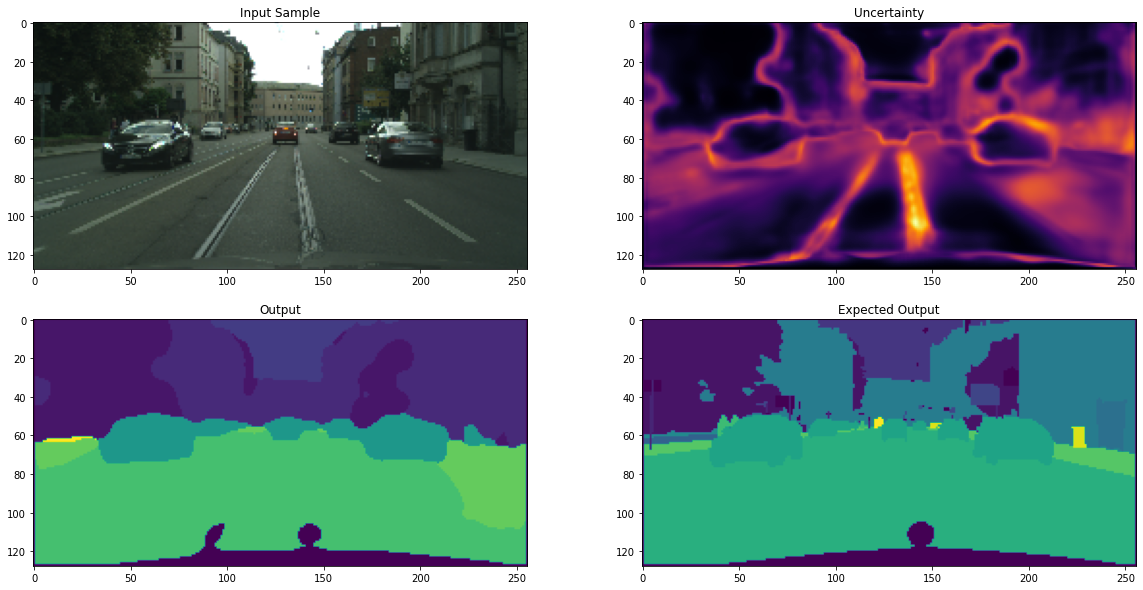

In [80]:
#Get mean uncertainty values of all classes 
uncertainty = tf.reduce_mean(risk_tensor.epistemic[0,:,:,:],axis=2)

#Get predicted y_hat value for each pixel in the image
output = tf.argmax(risk_tensor.y_hat[0,:,:,:],axis=2)

#Get the expected output
expected = y_test[SAMPLE_NUM,:,:,0]


plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,2,figsize=(20, 10)) 

axarr[0,0].title.set_text('Input Sample')
axarr[0,1].title.set_text('Uncertainty')
axarr[1,0].title.set_text('Output')
axarr[1,1].title.set_text('Expected Output')

# use the created array to output your multiple images. 
axarr[0,0].imshow(single_sample[0])
axarr[0,1].imshow(uncertainty,cmap='inferno')
axarr[1,0].imshow(output)
axarr[1,1].imshow(expected)

plt.show()
